# Homework 2 MLOPS

Jerzy Boksa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import requests
import psycopg
from pathlib import Path
import os
import gzip
import shutil

## 1. Download data

In [3]:
DATA_DIR = "./data"
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)


def download_data(url: str, name: str) -> None:
    response = requests.get(url)
    response.raise_for_status()

    file_path = Path(os.path.join(DATA_DIR, name))
    file_path.write_bytes(response.content)

    print(
        f"Downloaded '{name}', size: {file_path.stat().st_size / (1024 * 1024):.2f} mb"
    )


def download_and_unpack(url: str, name: str) -> None:
    response = requests.get(url)
    response.raise_for_status()

    gz_path = Path(os.path.join(DATA_DIR, name + ".gz"))
    gz_path.write_bytes(response.content)

    csv_path = Path(os.path.join(DATA_DIR, name))

    with gzip.open(gz_path, "rb") as f_in:
        with open(csv_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    print(
        f"Downloaded and unpacked '{name}', size: {csv_path.stat().st_size / (1024 * 1024):.2f} MB"
    )

    gz_path.unlink()

### Inter station distances

In [17]:
download_data(
    "https://opendata.rijdendetreinen.nl/public/tariff-distances/tariff-distances-2022-01.csv",
    "distances_2022.csv",
)

Downloaded 'distances_2022.csv', size: 0.56 mb


### Railway stations

In [31]:
download_data(
    "https://opendata.rijdendetreinen.nl/public/stations/stations-2023-09.csv",
    "stations_2023.csv",
)

Downloaded 'stations_2023.csv', size: 0.06 mb


### Train disruptions

In [4]:
disruption_paths = []
disruption_years = [i for i in range(2011, 2024)]


for year in disruption_years:
    filename = f"disruptions_{year}.csv"
    download_data(
        f"https://opendata.rijdendetreinen.nl/public/disruptions/disruptions-{year}.csv",
        filename,
    )

    disruption_paths.append(os.path.join(DATA_DIR, filename))

Downloaded 'disruptions_2011.csv', size: 0.39 mb
Downloaded 'disruptions_2012.csv', size: 0.45 mb
Downloaded 'disruptions_2013.csv', size: 0.49 mb
Downloaded 'disruptions_2014.csv', size: 0.52 mb
Downloaded 'disruptions_2015.csv', size: 0.62 mb
Downloaded 'disruptions_2016.csv', size: 0.64 mb
Downloaded 'disruptions_2017.csv', size: 1.21 mb
Downloaded 'disruptions_2018.csv', size: 1.51 mb
Downloaded 'disruptions_2019.csv', size: 1.76 mb
Downloaded 'disruptions_2020.csv', size: 1.28 mb
Downloaded 'disruptions_2021.csv', size: 1.37 mb
Downloaded 'disruptions_2022.csv', size: 1.62 mb
Downloaded 'disruptions_2023.csv', size: 1.56 mb


### Train services

In [29]:
services_paths = []
services_years = [
    i for i in range(2019, 2025)
]  # note that only until 2024 year, there is no 2025.csv file

for year in services_years:
    # for month in range(1, 13):
    filename = f"services_{year}.csv"
    download_and_unpack(
        f"https://opendata.rijdendetreinen.nl/public/services/services-{year}.csv.gz",
        filename,
    )

    services_paths.append(os.path.join(DATA_DIR, filename))

Downloaded and unpacked 'services_2019.csv', size: 2955.13 MB
Downloaded and unpacked 'services_2020.csv', size: 3172.24 MB
Downloaded and unpacked 'services_2021.csv', size: 3119.90 MB
Downloaded and unpacked 'services_2022.csv', size: 3147.50 MB
Downloaded and unpacked 'services_2023.csv', size: 3067.05 MB
Downloaded and unpacked 'services_2024.csv', size: 3162.43 MB


## 2. Stations into duckdb 

In [5]:
duckdb.sql("""
CREATE TABLE IF NOT EXISTS stations AS
SELECT * FROM read_csv_auto('data/stations_2023.csv')
""")

duckdb.sql("DESCRIBE stations")

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ id          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ code        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ uic         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ name_short  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ name_medium │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ name_long   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ slug        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ country     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ type        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ geo_lat     │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ geo_lng     │ DOUB

## 3. distances and distances_long tables

In [6]:
duckdb.sql("""
CREATE TABLE IF NOT EXISTS distances AS
SELECT * FROM read_csv_auto('data/distances_2022.csv')
""")

duckdb.sql(
    """
        FROM (DESCRIBE distances)
        LIMIT 5;
    """
)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [7]:
duckdb.sql(
    """
      CREATE TABLE IF NOT EXISTS distances_long AS
        UNPIVOT distances
        ON COLUMNS (* EXCLUDE station)
        INTO NAME other_station VALUE distance;
    """
)

duckdb.sql(
    """
        SELECT station, other_station, distance
        FROM distances_long
        LIMIT 3;
    """
)

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │ varchar  │
├─────────┼───────────────┼──────────┤
│ AC      │ AC            │ XXX      │
│ AC      │ AH            │ 82       │
│ AC      │ AHP           │ 83       │
└─────────┴───────────────┴──────────┘

## 4. Put train disruptions into disruptions table in the Postgres database

### Connection

In [8]:
duckdb.sql("""INSTALL postgres; LOAD postgres;""")
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

duckdb.sql(
    f"""
        ATTACH IF NOT EXISTS '{conn_string}' AS pg (TYPE postgres, READ_WRITE);
    """
)

### Add files

In [9]:
dfs = []
for csv_path in disruption_paths:
    csv_path = Path(csv_path)
    year = int(csv_path.stem.split("_")[1])
    df = pd.read_csv(csv_path)
    df["year"] = year
    dfs.append(df)

all_disruptions = pd.concat(dfs, ignore_index=True)

In [10]:
for csv_path in disruption_paths:
    duckdb.sql("""
            CREATE TABLE IF NOT EXISTS pg.disruptions AS
            SELECT * FROM all_disruptions
    """)

duckdb.sql("""
           SELECT COUNT(*) FROM  pg.disruptions
           """)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│        49900 │
└──────────────┘

## 5. Transform train services CSV files into a single Parquet file and make table services.

In [ ]:
csv_paths_str = ", ".join(f"'{str(f)}'" for f in services_paths)

duckdb.sql(f"""
    COPY (
        SELECT * FROM read_csv_auto([{csv_paths_str}])
    ) TO 'data/services.parquet' (FORMAT PARQUET)
""")

In [13]:
duckdb.sql(
    """
SELECT COUNT(*) FROM read_parquet('data/services.parquet');
    """
)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│    129950013 │
└──────────────┘

In [2]:
# duckdb.sql("""
#     CREATE TABLE IF NOT EXISTS services AS
#     SELECT * FROM read_parquet('data/services.parquet')
# """)


# MEMORY PROBLEMS THERE TO CREATE TABLE FROM ALL YEARS, COMPUTER CRASHES :(

duckdb.sql(
    """
        SELECT COUNT(*) FROM read_parquet('data/services.parquet');
    """
)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│    129950013 │
└──────────────┘

In [11]:
recent_services = [
    "data/services_2024.csv",
    # "data/services_2023.csv",
    # "data/services_2022.csv",
]
csv_paths_str = ", ".join(f"'{str(f)}'" for f in recent_services)


duckdb.sql(f"""
    COPY (
        SELECT * FROM read_csv_auto([{csv_paths_str}])
    ) TO 'data/services_small.parquet' (FORMAT PARQUET)
""")


duckdb.sql("""
    CREATE TABLE IF NOT EXISTS services AS 
    SELECT * FROM read_parquet('data/services_small.parquet')
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## 6. 7 Queries

### i. How many trains departed from Amsterdam Central station overall?


In [15]:
duckdb.sql(
    """
    SELECT COUNT(*) from services s
    WHERE s."Stop:Departure time" IS NOT NULL 
    AND s."Stop:Station code" = 'ASD'
"""
)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       267099 │
└──────────────┘

### ii. Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay

In [16]:
duckdb.sql(
    """
    SELECT 
        AVG(COALESCE(s."Stop:Arrival delay", 0)) AS avg_delay,
        s."Service:Type" as type
    FROM services s
    GROUP BY s."Service:Type"
    ORDER BY avg_delay DESC
"""
)

┌───────────────────────┬───────────────────┐
│       avg_delay       │       type        │
│        double         │      varchar      │
├───────────────────────┼───────────────────┤
│    10.938271604938272 │ European Sleeper  │
│                   8.0 │ Stoomtrein        │
│     7.729795462700849 │ Nightjet          │
│     6.191587512856192 │ Eurostar          │
│     6.023166974738139 │ ICE International │
│    3.4217391304347826 │ Nachttrein        │
│    3.2816901408450705 │ Int. Trein        │
│    2.6484688352141443 │ Intercity direct  │
│    2.3796818149390027 │ Extra trein       │
│    1.9153005464480874 │ Eurocity Direct   │
│    1.5470227660067766 │ Sneltrein         │
│     1.347713386409924 │ EuroCity          │
│    1.1113020797737811 │ Intercity         │
│    0.7834182353591754 │ Sprinter          │
│    0.7000531187700209 │ Stoptrein         │
│    0.6510134081696289 │ Speciale Trein    │
│ 0.0004128890519107161 │ Stopbus ipv trein │
│ 2.973472378565512e-05 │ Snelbus 

### iii. What was the most common disruption cause in different years? MODE function may be useful.


In [17]:
duckdb.sql(
    """
    SELECT 
        d.YEAR as year,
        MODE(d.cause_en) as most_disruption_cause,
    FROM pg.disruptions d
    GROUP BY d.YEAR
    ORDER BY d.YEAR
"""
)

┌───────┬───────────────────────┐
│ year  │ most_disruption_cause │
│ int64 │        varchar        │
├───────┼───────────────────────┤
│  2011 │ broken down train     │
│  2012 │ points failure        │
│  2013 │ points failure        │
│  2014 │ broken down train     │
│  2015 │ broken down train     │
│  2016 │ broken down train     │
│  2017 │ broken down train     │
│  2018 │ broken down train     │
│  2019 │ broken down train     │
│  2020 │ broken down train     │
│  2021 │ broken down train     │
│  2022 │ broken down train     │
│  2023 │ broken down train     │
├───────┴───────────────────────┤
│ 13 rows             2 columns │
└───────────────────────────────┘

### iv. How many trains started their overall service in any Amsterdam station?


In [18]:
duckdb.sql(
    """
    SELECT 
        COUNT(DISTINCT "Service:RDT-ID") as starts_in_amsterdam
        FROM services s
        JOIN stations st ON s."Stop:Station code" = st.code
        WHERE s."Stop:Arrival time" IS NULL AND st.name_long LIKE '%Amsterdam%'
"""
)

┌─────────────────────┐
│ starts_in_amsterdam │
│        int64        │
├─────────────────────┤
│              166209 │
└─────────────────────┘

### v. What fraction of services was run to final destinations outside the Netherlands?


In [19]:
duckdb.sql(
    """ 
    WITH intenrational_final_stations AS (
        SELECT 
            s."Service:RDT-ID",
            st.country,
            s."Service:Date"
        FROM services s 
        JOIN stations st ON s."Stop:Station code" = st.code
        WHERE s."Stop:Departure time" IS NULL
    )
    SELECT 
        COUNTIF(country <> 'NL') * 1.0 / COUNT(*) AS fraction_outside_nl
    FROM intenrational_final_stations;
    """
)

┌─────────────────────┐
│ fraction_outside_nl │
│       double        │
├─────────────────────┤
│ 0.04071952052989696 │
└─────────────────────┘

### vi. What is the largest distance between stations in the Netherlands (code NL)?

In [20]:
duckdb.sql(
    """
    DESCRIBE distances_long
    """
)

┌───────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type │  null   │   key   │ default │  extra  │
│    varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ other_station │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ distance      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [21]:
duckdb.sql(
    """
    DESCRIBE stations
    """
)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ id          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ code        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ uic         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ name_short  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ name_medium │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ name_long   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ slug        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ country     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ type        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ geo_lat     │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ geo_lng     │ DOUB

In [22]:
duckdb.sql(
    """ 
    SELECT 
        CAST(d.distance AS DOUBLE) AS max_distance_km,
        s_from.name_long AS from_station,
        s_to.name_long AS to_station
    FROM distances_long d
    JOIN stations s_from ON d.Station = s_from.code
    JOIN stations s_to ON d.other_station = s_to.code
    WHERE s_from.country = 'NL'
    AND s_to.country = 'NL'
    AND d.distance != 'XXX'
    ORDER BY max_distance_km DESC
    LIMIT 1;
    """
)

┌─────────────────┬──────────────┬────────────┐
│ max_distance_km │ from_station │ to_station │
│     double      │   varchar    │  varchar   │
├─────────────────┼──────────────┼────────────┤
│           426.0 │ Vlissingen   │ Eemshaven  │
└─────────────────┴──────────────┴────────────┘

### vii. Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.

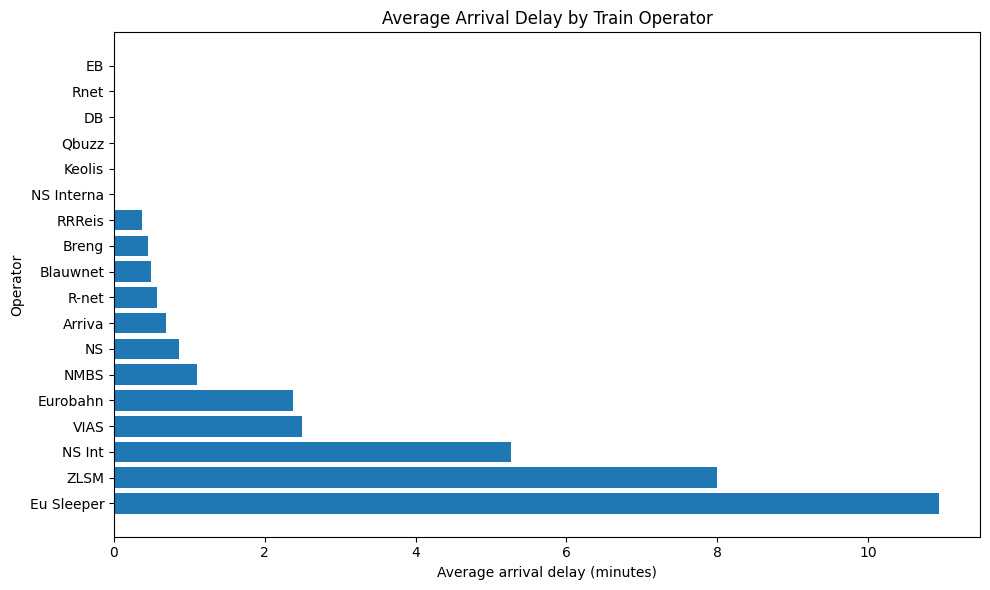

In [23]:
delays_df = duckdb.sql("""
    SELECT 
        s."Service:Company" as operator,
        AVG(COALESCE("Stop:Arrival delay", 0)) as avg_delay
        FROM services s
        GROUP BY s."Service:Company"
        ORDER BY avg_delay DESC;
""").df()

plt.figure(figsize=(10, 6))
plt.barh(delays_df["operator"], delays_df["avg_delay"])
plt.xlabel("Average arrival delay (minutes)")
plt.ylabel("Operator")
plt.title("Average Arrival Delay by Train Operator")
plt.tight_layout()
plt.show()


### viii. How many services were disrupted in different years? Make a line plot.


In [39]:
duckdb.sql(
    """
    SELECT COUNT(DISTINCT d.year) FROM pg.disruptions d
    """
)

┌──────────────────────────┐
│ count(DISTINCT d."year") │
│          int64           │
├──────────────────────────┤
│                       13 │
└──────────────────────────┘

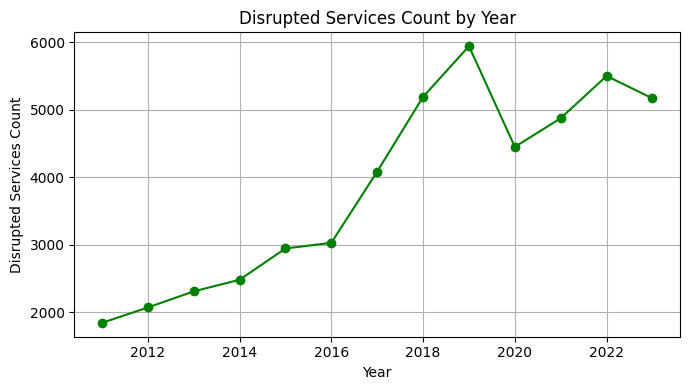

In [53]:
disruptions_df = duckdb.sql("""
    SELECT 
        d.year as year,
        COUNT(DISTINCT d.rdt_id) AS disrupted_services
    FROM pg.disruptions d
    GROUP BY d.year
    ORDER BY d.year;
""").df()

disruptions_df

plt.figure(figsize=(7, 4))
plt.plot(
    disruptions_df["year"], disruptions_df["disrupted_services"], c="g", marker="o"
)
plt.xlabel("Year")
plt.ylabel("Disrupted Services Count")
plt.grid()
plt.title("Disrupted Services Count by Year")
plt.tight_layout()
plt.show()

### ix. What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.


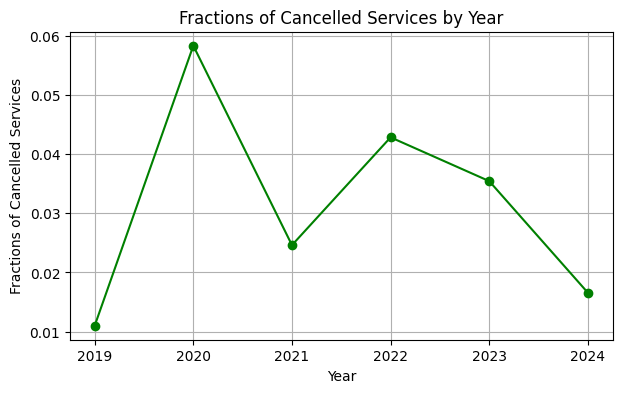

In [58]:
# NOTE THAT THIS IS READ FROM PARQUET (in service there is only 1 year - couldnt load full table into ram)
cancelled_fraction_df = duckdb.sql("""
    SELECT 
        EXTRACT(YEAR FROM s."Service:Date") AS year,
        COUNT(*) AS total_services,
        COUNTIF(s."Service:Completely cancelled" = TRUE) * 1.0 / COUNT(*) AS fraction_cancelled
    FROM read_parquet('data/services.parquet') s
    GROUP BY year
    ORDER BY year;
""").df()

cancelled_fraction_df

plt.figure(figsize=(7, 4))
plt.plot(
    cancelled_fraction_df["year"],
    cancelled_fraction_df["fraction_cancelled"],
    c="g",
    marker="o",
)
plt.xlabel("Year")
plt.ylabel("Fractions of Cancelled Services")
plt.grid()
plt.title("Fractions of Cancelled Services by Year")
plt.show()

## 8. station_connection table

### i. LEAD

`lead(expr[, offset[, default]][ ORDER BY ordering][ IGNORE NULLS])`

Returns expr evaluated at the row that is offset rows after the current row (among rows with a non-null value of expr if IGNORE NULLS is set) within the window frame; if there is no such row, instead return default (which must be of the Same type as expr). Both offset and default are evaluated with respect to the current row. If omitted, offset defaults to 1 and default to NULL.


**FILTER**


The FILTER clause may optionally follow an aggregate function in a SELECT statement. This will filter the rows of data that are fed into the aggregate function in the same way that a WHERE clause filters rows, but localized to the specific aggregate function.

There are multiple types of situations where this is useful, including when evaluating multiple aggregates with different filters, and when creating a pivoted view of a dataset. FILTER provides a cleaner syntax for pivoting data when compared with the more traditional CASE WHEN approach discussed below.

Some aggregate functions also do not filter out NULL values, so using a FILTER clause will return valid results when at times the CASE WHEN approach will not. This occurs with the functions first and last, which are desirable in a non-aggregating pivot operation where the goal is to simply re-orient the data into columns rather than re-aggregate it. FILTER also improves NULL handling when using the list and array_agg functions, as the CASE WHEN approach will include NULL values in the list result, while the FILTER clause will remove them.

### ii. Create station_connections

In [25]:
duckdb.sql(
    """
        CREATE TABLE station_connections AS
        WITH service_ends AS (
            SELECT
                s."Service:RDT-ID" AS service_id,
                MIN(s."Stop:Station code") FILTER (WHERE s."Stop:Arrival time" IS NULL) AS start_station_code,
                MAX(s."Stop:Station code") FILTER (WHERE s."Stop:Departure time" IS NULL) AS end_station_code
            FROM services s
            GROUP BY s."Service:RDT-ID"
        )
        SELECT DISTINCT
            se.service_id,
            se.start_station_code,
            se.end_station_code,
            d.distance AS distance_km
        FROM service_ends se
        JOIN distances_long d
            ON se.start_station_code = d.Station
        AND se.end_station_code = d.other_station;
    """
)


In [26]:
duckdb.sql(
    """
    SELECT COUNT(*) FROM station_connections
    """
)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      2235932 │
└──────────────┘

### iii. What is the largest distance between a pair of stations?


In [30]:
duckdb.sql(
    """
        SELECT 
            start_station_code,
            end_station_code,
            distance_km AS max_distance_km
        FROM station_connections
        WHERE max_distance_km != 'XXX'
        ORDER BY distance_km DESC
        LIMIT 1;
    """
)

┌────────────────────┬──────────────────┬─────────────────┐
│ start_station_code │ end_station_code │ max_distance_km │
│      varchar       │     varchar      │     varchar     │
├────────────────────┼──────────────────┼─────────────────┤
│ GVC                │ HNK              │ 99              │
└────────────────────┴──────────────────┴─────────────────┘

### iv. Plot a histogram of inter-station distances run by trains.



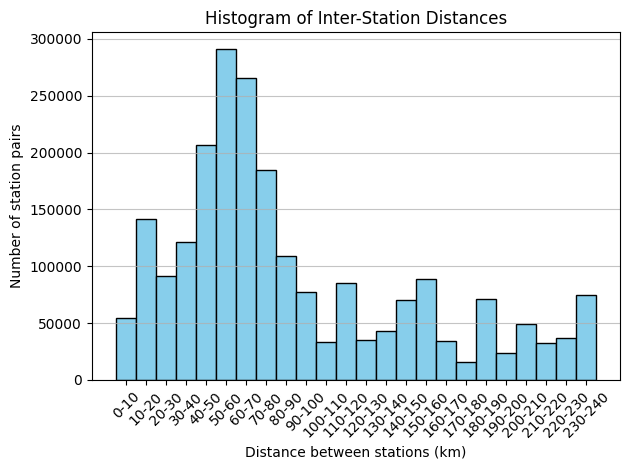

In [62]:
distances_df = duckdb.sql(
    """
        SELECT sc.distance_km 
        FROM station_connections sc
        WHERE sc.distance_km IS NOT NULL
        ORDER BY sc.distance_km DESC
    """
).df()

bins = np.arange(0, 250, 10)

counts, bin_edges, _ = plt.hist(
    distances_df["distance_km"], bins=bins, color="skyblue", edgecolor="black"
)

bin_labels = [
    f"{int(start)}-{int(end)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])
]

plt.xticks(ticks=(bin_edges[:-1] + bin_edges[1:]) / 2, labels=bin_labels, rotation=45)

plt.xlabel("Distance between stations (km)")
plt.ylabel("Number of station pairs")
plt.title("Histogram of Inter-Station Distances")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()
